# Gaussian Process Analysis 

Train on 2018, and test on 2019

Use gaussian process becuase of spatial capability

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import os
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import K2Score, BicScore, BDeuScore, HillClimbSearch, BayesianEstimator
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.factors.discrete.CPD import TabularCPD
from shapely.geometry import Point
from sklearn.mixture import GaussianMixture
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel,RationalQuadratic,Exponentiation,ExpSineSquared
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)
np.set_printoptions(threshold=np.inf)

In [2]:
# Parameters
parent_dir = os.path.abspath('..')  # get the absolute path of the parent directory
file_path = os.path.join(parent_dir, 'Data', 'rodents_per_year_merged.csv')  # construct the file path
rodents_df = pd.read_csv(file_path)
print(len(rodents_df))
rodents_df.head()

38958


,spatial_id,year,l_Commercial_sum,l_Other_sum,l_Outdoor_sum,l_Residential_sum,l_Residential-Mixed_sum,l_Vacant_Space_sum,d_Friday_sum,d_Monday_sum,d_Saturday_sum,d_Sunday_sum,d_Thursday_sum,d_Tuesday_sum,d_Wednesday_sum,t_Evening_sum,t_Midday_sum,t_Morning_sum,num_sightings,s_Dead_Animal:Residential_sum,s_Dead_Animal:Street_sum,s_Dog_waste:Street_sum,s_Illegal_Dumping:Street_sum,s_Trash:Residential_sum,s_Trash:Street_sum,s_Trash_MissedService:Street_sum,s_Trash_Overflowing:Street_sum,s_Trash_Time:Street_sum,s_Trash_Unsecure:Residential_sum,s_Trash_Unsecure:Street_sum,num_dsny_complaints,subway_count,v_flies_sum,v_rats/mice_sum,v_roaches_sum,c_American_sum,c_Bakery Products/Desserts_sum,c_Caribbean_sum,c_Chinese_sum,c_Coffee/Tea_sum,c_Italian_sum,c_Japanese_sum,c_Latin American_sum,c_Mexican_sum,c_Pizza_sum,c_other_sum,num_violations
0,360050001000,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,360050001000,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,360050001000,2022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,360050001000,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,360050001000,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Get the lat lng 

parent_dir = os.path.abspath('..')  # get the absolute path of the parent directory
file_path = os.path.join(parent_dir, 'Data', 'nyc_bgrp.geojson')  # construct the file path
cb_gdf = gpd.read_file(file_path)  # load the GeoJSON file into a GeoDataFrame
rodents_df['spatial_id'] = rodents_df['spatial_id'].astype(str)
rodents_joined_tracts_gdf = pd.merge(cb_gdf[['geometry','spatial_id']], rodents_df, how='left')

rodents_gdf = rodents_joined_tracts_gdf[rodents_joined_tracts_gdf.geometry.notnull()]

# Extract the coordinates of the points
rodents_gdf['x'] = rodents_gdf.apply(lambda x: (x['geometry'].centroid.x), axis=1)
rodents_gdf['y'] = rodents_gdf.apply(lambda x: (x['geometry'].centroid.y), axis=1)

# Feature Selection

In [4]:
df = rodents_df.filter(regex='^(?!t_|d_|l_).*')
#df = df[df['year']==2019]
df = df.drop(['year','spatial_id','num_dsny_complaints','num_violations'], axis=1)
df.head()

,num_sightings,s_Dead_Animal:Residential_sum,s_Dead_Animal:Street_sum,s_Dog_waste:Street_sum,s_Illegal_Dumping:Street_sum,s_Trash:Residential_sum,s_Trash:Street_sum,s_Trash_MissedService:Street_sum,s_Trash_Overflowing:Street_sum,s_Trash_Time:Street_sum,s_Trash_Unsecure:Residential_sum,s_Trash_Unsecure:Street_sum,subway_count,v_flies_sum,v_rats/mice_sum,v_roaches_sum,c_American_sum,c_Bakery Products/Desserts_sum,c_Caribbean_sum,c_Chinese_sum,c_Coffee/Tea_sum,c_Italian_sum,c_Japanese_sum,c_Latin American_sum,c_Mexican_sum,c_Pizza_sum,c_other_sum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [6]:
# calculate the correlation matrix
corr_matrix = df_scaled.corr()

# find the fields with the highest correlation to the target variable
target_var = 'num_sightings'
corr_values = corr_matrix[target_var]
highest_corr_fields = list(corr_values[corr_values.abs() > 0.05].index)

# create a new dataframe with only the selected fields
rodents_pc_df = df_scaled[highest_corr_fields]
rodents_pc_df.head()

,num_sightings,s_Illegal_Dumping:Street_sum,s_Trash:Residential_sum,s_Trash:Street_sum,s_Trash_Overflowing:Street_sum,s_Trash_Time:Street_sum,s_Trash_Unsecure:Residential_sum,s_Trash_Unsecure:Street_sum,subway_count,v_flies_sum,v_rats/mice_sum,v_roaches_sum,c_American_sum,c_Coffee/Tea_sum,c_Mexican_sum,c_Pizza_sum,c_other_sum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
highest_corr_fields

['num_sightings',
 's_Illegal_Dumping:Street_sum',
 's_Trash:Residential_sum',
 's_Trash:Street_sum',
 's_Trash_Overflowing:Street_sum',
 's_Trash_Time:Street_sum',
 's_Trash_Unsecure:Residential_sum',
 's_Trash_Unsecure:Street_sum',
 'subway_count',
 'v_flies_sum',
 'v_rats/mice_sum',
 'v_roaches_sum',
 'c_American_sum',
 'c_Coffee/Tea_sum',
 'c_Mexican_sum',
 'c_Pizza_sum',
 'c_other_sum']

# Gaussian Process

In [8]:
fields = ['x','y'] +highest_corr_fields
rodent_2018_gdf = rodents_gdf[rodents_gdf['year']==2018]
rodent_2018_gdf[fields].head()

rodent_2019_gdf = rodents_gdf[rodents_gdf['year']==2019]
rodent_2019_gdf[fields].head()

,x,y,num_sightings,s_Illegal_Dumping:Street_sum,s_Trash:Residential_sum,s_Trash:Street_sum,s_Trash_Overflowing:Street_sum,s_Trash_Time:Street_sum,s_Trash_Unsecure:Residential_sum,s_Trash_Unsecure:Street_sum,subway_count,v_flies_sum,v_rats/mice_sum,v_roaches_sum,c_American_sum,c_Coffee/Tea_sum,c_Mexican_sum,c_Pizza_sum,c_other_sum
4,-73.883048,40.795098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,-73.882662,40.791099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,-73.858518,40.806466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,-73.860866,40.813963,4.0,9.0,10.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,-73.860656,40.811756,3.0,22.0,3.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Standardize 

mean_num_sightings = rodent_2018_gdf['num_sightings'].mean()
print(mean_num_sightings)
rodent_2018_gdf['num_sightings_standardized'] = rodent_2018_gdf['num_sightings'] - mean_num_sightings


2.4533498375367477


In [10]:
# Prep the input data 
# TODO Perhaps add more variables or does this only work with one?
X = rodent_2018_gdf[['x','y']]
y = rodent_2018_gdf['num_sightings_standardized']

print(len(X))
print(len(y))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print(len(X_train))
print(len(X_test))



6463
6463
5170
1293


In [11]:
# This takes forever,  GPs take O(n^3)  216 billion operations :(
rbf_kernel = 10.**2 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
white_noise_kernel = WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e10))
k3 = 10.**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
k4 = 10.**2 * Exponentiation(exponent=2.0, kernel=rbf_kernel)
kernel = 1. * rbf_kernel + white_noise_kernel + k3 + k4

# Initiate the gaussian process model 
gp = GaussianProcessRegressor(kernel=kernel,random_state=1)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X_train, y_train)

y_pred, sigma = gp.predict(X_train, return_std=True)

In [12]:
print(gp.log_marginal_likelihood_value_)
print(gp.kernel_)

-14877.044101125151
0.251**2 * 2.51**2 * RBF(length_scale=3.89) + WhiteKernel(noise_level=0.00284) + 4.35**2 * RationalQuadratic(alpha=0.365, length_scale=0.00012) + 4.42**2 * 0.503**2 * RBF(length_scale=0.0481) ** 2.0


<AxesSubplot:>

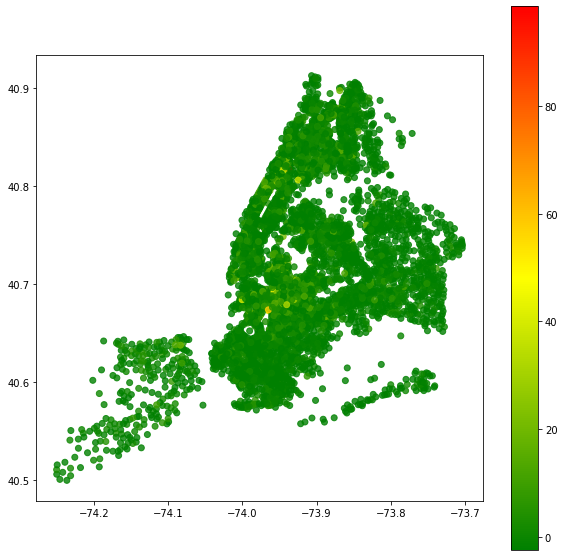

In [13]:
cmap = LinearSegmentedColormap.from_list('green_to_red', ['green', 'yellow', 'red'])

geometry = [Point(xy) for xy in zip(X_train.x, X_train.y)]
gdf = gpd.GeoDataFrame(X_train, crs='epsg:4326', geometry=geometry)
gdf.plot(column=y_train, cmap=cmap, legend=True, figsize=(10,10), alpha=0.8)

<AxesSubplot:>

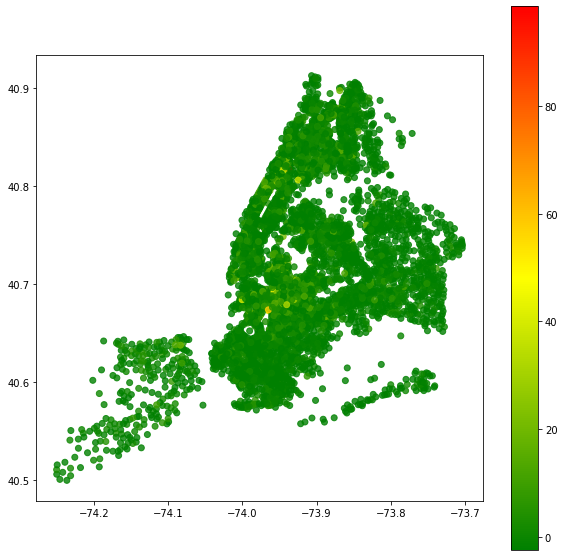

In [14]:
geometry = [Point(xy) for xy in zip(X_train.x, X_train.y)]
gdf = gpd.GeoDataFrame(X_train, crs='epsg:4326', geometry=geometry)
gdf.plot(column=y_pred, cmap=cmap, legend=True, figsize=(10,10), alpha=0.8)